In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn

### Load and Display Images

In [2]:
salinas = np.load('salinas.npy', allow_pickle=True)
salinas_gt = np.load('salinas_gt.npy', allow_pickle=True)
print(salinas.shape)
print(salinas_gt.shape)

(512, 217, 204)
(512, 217)


In [3]:
indiana_pines = np.load('indianapines.npy', allow_pickle=True)
indiana_pines_gt = np.load('indianapines_gt.npy', allow_pickle=True)
print(indiana_pines.shape)
print(indiana_pines_gt.shape)

(145, 145, 200)
(145, 145)


In [4]:
def plot_RGB(image):
    imageRGB = np.array(image[:, :, [30, 15, 2]], dtype=float)

    pmin,pmax = np.percentile(imageRGB, (1,99), axis=(0,1))
    print(pmin, pmax)
    imageRGB_pimped = imageRGB.copy()

    for i in range(pmin.size):
        imageRGB_pimped[:,:,i] = (imageRGB[:,:,i] - pmin[i]) / (pmax[i] - pmin[i])

    imageRGB_pimped[imageRGB_pimped < 0] = 0
    imageRGB_pimped[imageRGB_pimped > 1] = 1

    plt.figure(figsize=(5,5))
    plt.imshow(imageRGB_pimped)
    plt.show()

[ 600. 1045.  474.] [3747. 3107.  927.]


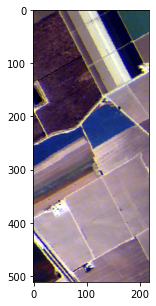

In [5]:
plot_RGB(salinas)

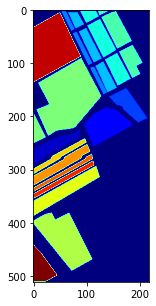

In [6]:
plt.figure(figsize=(5,5))
plt.imshow(salinas_gt, cmap='jet')

[2353. 2761. 3833.] [5442.   6051.76 4946.  ]


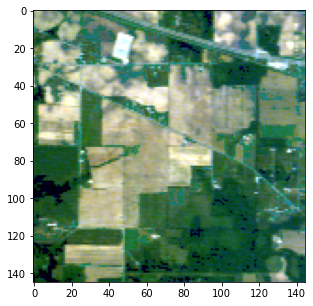

In [7]:
plot_RGB(indiana_pines)

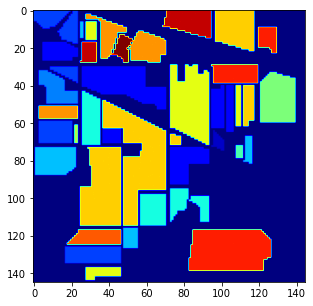

In [8]:
plt.figure(figsize=(5,5))
plt.imshow(indiana_pines_gt, cmap='jet')

### Loading Dataset

We chose to remove the zero labelized data from the dataset as it is non labelized data so unfit to be used in supervised learning.

In [9]:
def flatten_image(X):
    return X.reshape((-1, X.shape[-1]))
X1 = flatten_image(salinas)
Y1 = salinas_gt.flatten()

# We remove the non labelized data from the dataset.
X1 = X1[Y1!=0]
Y1 = Y1[Y1!=0]
Y1 = Y1 - 1
values, count = np.unique(Y1, return_counts=True)
print(values, '\n', count)
print(X1.shape)
print(Y1.shape)

X2 = flatten_image(indiana_pines)
Y2 = indiana_pines_gt.flatten()

X2 = X2[Y2!=0]
Y2 = Y2[Y2!=0]
Y2 = Y2 - 1
print(X2.shape)
print(Y2.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
 [ 2009  3726  1976  1394  2678  3959  3579 11271  6203  3278  1068  1927
   916  1070  7268  1807]
(54129, 204)
(54129,)
(10249, 200)
(10249,)


In [10]:
from sklearn.model_selection import train_test_split
#We split the dataset into training set and test set to measure overfitting.
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=1, stratify=Y1)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=1, stratify=Y2)
print(X1_train.shape)
print(X2_train.shape)

(43303, 204)
(8199, 200)


### Component analysis

We make a quick visualisation of the principal components of the normalized data. To give us an intuition of the data complexity.

The PCA is not used in our final pipeline as it drastically decreases the classifiers accuracy even with 99.9% of the data variance.

In [11]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import Normalizer

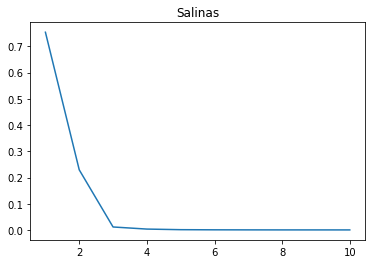

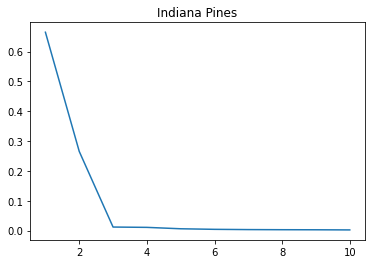

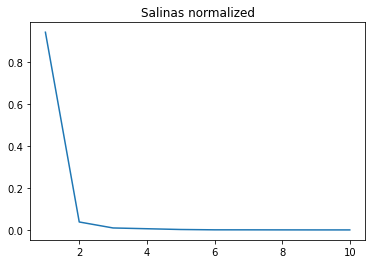

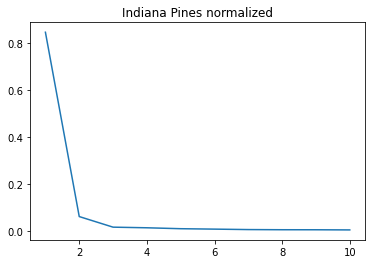

In [12]:

def pca_components(X, name):
    pca = PCA(n_components=10)
    pca.fit(X)

    plt.plot(np.arange(1, 11), pca.explained_variance_ratio_)
    plt.title(name)
    plt.show()

pca_components(X1, "Salinas")
pca_components(X2, "Indiana Pines")
pca_components(Normalizer().fit_transform(X1), "Salinas normalized")
pca_components(Normalizer().fit_transform(X2), "Indiana Pines normalized")

Variance greater than 0.999: 5


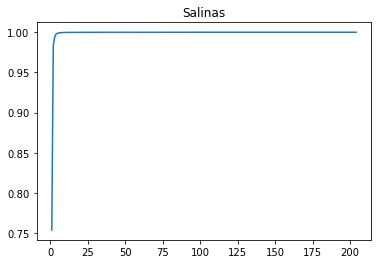

Variance greater than 0.999: 66


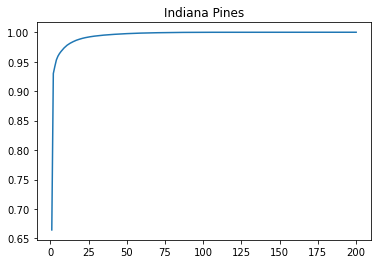

Variance greater than 0.999: 7


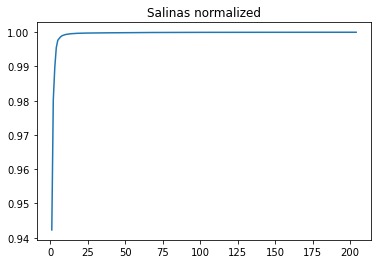

Variance greater than 0.999: 73


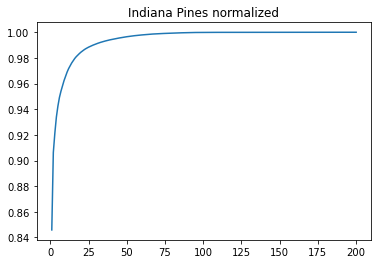

In [13]:
def pca_components_cumsum(X, name):
    pca = PCA()
    pca.fit(X)

    variances = np.cumsum(pca.explained_variance_ratio_)
    print("Variance greater than 0.999:", np.argmax(variances > 0.999))

    plt.plot(np.arange(1, X.shape[-1] + 1), variances)
    plt.title(name)
    plt.show()

pca_components_cumsum(X1, "Salinas")
pca_components_cumsum(X2, "Indiana Pines")
pca_components_cumsum(Normalizer().fit_transform(X1), "Salinas normalized")
pca_components_cumsum(Normalizer().fit_transform(X2), "Indiana Pines normalized")

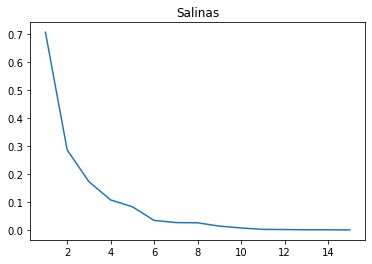

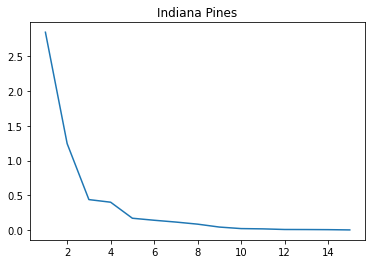

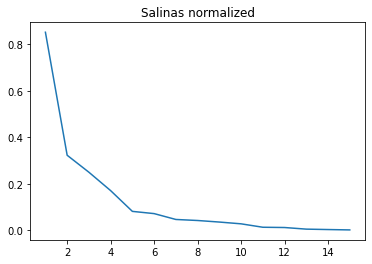

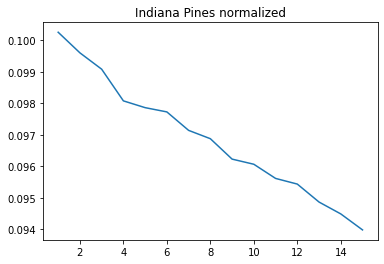

In [14]:
def lda_components(X, Y, name):
    lda = LDA(solver='eigen', shrinkage='auto')
    lda.fit(X, Y)

    plt.plot(np.arange(1, 16), lda.explained_variance_ratio_)
    plt.title(name)
    plt.show()

lda_components(X1, Y1, "Salinas")
lda_components(X2, Y2, "Indiana Pines")
lda_components(Normalizer().fit_transform(X1), Y1, "Salinas normalized")
lda_components(Normalizer().fit_transform(X2), Y2, "Indiana Pines normalized")

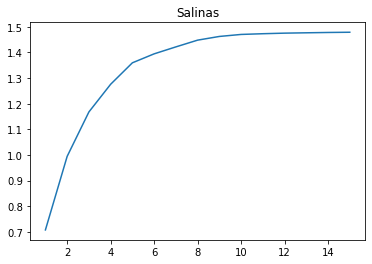

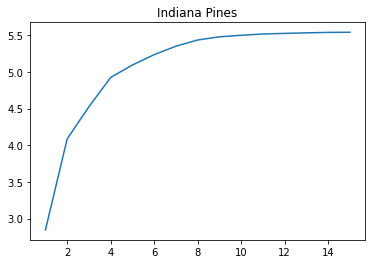

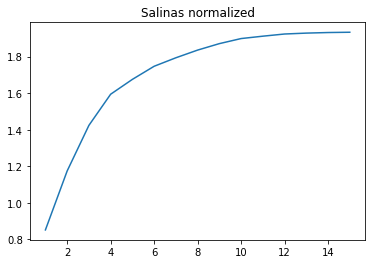

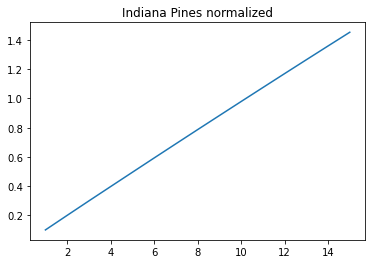

In [15]:
def lda_components_cumsum(X, Y, name):
    # the final pipeline uses shrinkage as it give better results for indiana pines.
    # But the variance ration loses its meaning (Not between 0 and 1)
    lda = LDA(solver='eigen', shrinkage='auto')
    lda.fit(X, Y)

    variances = np.cumsum(lda.explained_variance_ratio_)

    plt.plot(np.arange(1, 16), variances)
    plt.title(name)
    plt.show()

lda_components_cumsum(X1, Y1, "Salinas")
lda_components_cumsum(X2, Y2, "Indiana Pines")
lda_components_cumsum(Normalizer().fit_transform(X1), Y1, "Salinas normalized")
lda_components_cumsum(Normalizer().fit_transform(X2), Y2, "Indiana Pines normalized")

### Class Weights & names

Visualization of the class balanced weights. (We always let the classifier do it when possible)

In [16]:
classes_names_indiana_pines = ["Alfalfa", "Corn-notill", 
"Corn-mintill", "Corn", "Grass-pasture", "Grass-trees",
"Grass-pasture-mowed", "Hay-windrowed", "Oats", "Soybean-notill",
"Soybean-mintill", "Soybean-clean", "Wheat", "Woods", 
"Buildings-grass-Trees-Drives", "Stone-Steel-Towers"]

classes_names_salinas = ["Brocoli_green_weeds_1", 
"Brocoli_green_weeds_2", "Fallow", "Fallow_rough_plow", 
"Fallow_smooth", "Stubble", "Celery", "Grapes_untrained",
"Soil_vinyard_develop", "Corn_senesced_green_weeds", "Lettuce_romaine_4wk", 
"Lettuce_romaine_5wk", "Lettuce_romaine_6wk", "Lettuce_romaine_7wk", 
"Vinyard_untrained", "Vinyard_vertical_trellis"]

In [17]:
from sklearn.utils import class_weight
from pprint import pprint

In [18]:
def class_weights(y, names):
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weights = dict(zip(names, class_weights))

    pprint(class_weights)

    return class_weights
print("X1:")
class_weights1 = class_weights(Y1, classes_names_salinas)
print("X2:")
class_weights2 = class_weights(Y2, classes_names_indiana_pines)

X1:
{'Brocoli_green_weeds_1': 1.6839534594325536,
 'Brocoli_green_weeds_2': 0.9079609500805152,
 'Celery': 0.945253562447611,
 'Corn_senesced_green_weeds': 1.032050793166565,
 'Fallow': 1.7120761639676114,
 'Fallow_rough_plow': 2.4268741032998564,
 'Fallow_smooth': 1.263279499626587,
 'Grapes_untrained': 0.3001563747671014,
 'Lettuce_romaine_4wk': 3.1676615168539324,
 'Lettuce_romaine_5wk': 1.7556110534509601,
 'Lettuce_romaine_6wk': 3.6932996724890828,
 'Lettuce_romaine_7wk': 3.1617406542056075,
 'Soil_vinyard_develop': 0.5453913428985975,
 'Stubble': 0.8545245011366507,
 'Vinyard_untrained': 0.4654736516235553,
 'Vinyard_vertical_trellis': 1.8721983951300498}
X2:
{'Alfalfa': 13.925271739130435,
 'Buildings-grass-Trees-Drives': 1.659488341968912,
 'Corn': 2.702795358649789,
 'Corn-mintill': 0.771762048192771,
 'Corn-notill': 0.4485731792717087,
 'Grass-pasture': 1.3262163561076605,
 'Grass-pasture-mowed': 22.877232142857142,
 'Grass-trees': 0.8774828767123287,
 'Hay-windrowed': 1.3400

### Preprocessing

For the preprocessing we use normalization + LDA with eigen + shrinkage as it consequently speed up the classifiers as well as increasing their score.

In [19]:
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [20]:
normalizer = Normalizer()

In [21]:
lda = LDA(solver='eigen', shrinkage='auto')

### Classifiers

In [22]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis

In [23]:
extra_trees = ExtraTreesClassifier(n_estimators=500, max_features=6, n_jobs=11, criterion='entropy', class_weight='balanced_subsample')

In [24]:
random_forest = RandomForestClassifier(n_estimators=500, max_features=6, n_jobs=11, criterion='entropy', class_weight='balanced_subsample')

In [25]:
knn = KNeighborsClassifier(algorithm='kd_tree', leaf_size=19, n_neighbors=8, weights='distance')

In [26]:
svc = SVC(C=1.4, max_iter=600, gamma=0.05, class_weight=None, verbose=1, random_state=42)

### Pipelines

In [27]:
from sklearn.base import clone

In [28]:
pipelines = {}

In [29]:
pipeline_knn = Pipeline([('normalizer', Normalizer()), ('lda', LDA(solver='eigen', shrinkage='auto')),
    ('clf', knn)])
pipelines["knn"] = (pipeline_knn, clone(pipeline_knn))

In [30]:
pipeline_forest = Pipeline([('normalizer', Normalizer()), ('lda', LDA(solver='eigen', shrinkage='auto')),
    ('clf', random_forest)])
pipelines["forest"] = (pipeline_forest, clone(pipeline_forest))

In [31]:
pipeline_extra = Pipeline([('normalizer', Normalizer()), ('lda', LDA(solver='eigen', shrinkage='auto')),
    ('clf', extra_trees)])
pipelines["extra"] = (pipeline_extra, clone(pipeline_extra))

In [32]:
pipeline_svc = Pipeline([('normalizer', Normalizer()), ('lda', LDA(solver='eigen', shrinkage='auto')),
                         ('svc', SVC(C=0.9, max_iter=5000, gamma=0.1, class_weight=None, verbose=1, random_state=42))])
        
pipelines["svc"] = (pipeline_svc, clone(pipeline_svc))

### Custom Classifier (Outdated)

A classifier that considered returned the 0 label when none of the OVR binary classifiers had a clear classification.

In [33]:
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV

In [34]:
class MyClassifier(ClassifierMixin):
    def __init__(self, clf, class_weights=None):
        self.clf_ = clf
        self.class_weights_ = class_weights
    
    def fit(self, X, y):
        self.label_binarizer_ = LabelBinarizer(sparse_output=False)
        Y = self.label_binarizer_.fit_transform(y)
        columns = Y.T
        self.estimators_ = []

        for i, y_bin in enumerate(columns[1:]):
            print(i)
            clf_copy = clone(self.clf_)
            self.estimators_.append(clf_copy.fit(X, y_bin))
            
#         self.estimators_ = Parallel(n_jobs=self.n_jobs)(delayed(_fit_binary)(
#             self.estimator, X, column, classes=[
#                 "not %s" % self.label_binarizer_.classes_[i],
#                 self.label_binarizer_.classes_[i]])
#             for i, column in enumerate(columns))
        
    def predict(self, X):
        maxima = np.full(X.shape[0], -np.inf)
        argmaxima = np.zeros(X.shape[0], dtype=int)

        for i, e in enumerate(self.estimators_):
            proba_y = e.predict_proba(X)[:,1]
            np.maximum(maxima, proba_y, out=maxima)
            argmaxima[maxima == proba_y] = i + 1
            
        argmaxima[maxima < 0.3] = 0
        return argmaxima

### Training

In [35]:
from time import perf_counter

In [36]:
for name, (clf1, clf2) in pipelines.items():
    begin = perf_counter()
    print("training pipeline %s for X1" % name)
          
    clf1.fit(X1_train, Y1_train)
    print("%.3fs" % (perf_counter() - begin))
    begin = perf_counter()
    print("training pipeline %s for X2" % name)
    clf2.fit(X2_train, Y2_train)
    print("%.3fs" % (perf_counter() - begin))



training pipeline knn for X1
0.854s
training pipeline knn for X2
0.167s
training pipeline forest for X1
17.638s
training pipeline forest for X2
3.883s
training pipeline extra for X1
2.605s
training pipeline extra for X2
0.785s
training pipeline svc for X1
[LibSVM]

/home/simon/.miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


8.489s
training pipeline svc for X2
[LibSVM]1.056s


### Testing

In [37]:
from sklearn.metrics import *

In [38]:
for name, (clf1, clf2) in pipelines.items():
    print("pipeline %s:" % name)
    begin = perf_counter()
    Y1_pred = clf1.predict(X1_test)
    time = (perf_counter() - begin)
    print("X1 accuracy: %.4f, balanced accuracy: %.4f, f1_score: %.4f" % (accuracy_score(Y1_test, Y1_pred), balanced_accuracy_score(Y1_test, Y1_pred), f1_score(Y1_test, Y1_pred, average='weighted')))
    print("%.3fs" % time)

    begin = perf_counter()    
    Y2_pred = clf2.predict(X2_test)
    time = (perf_counter() - begin)

    print("X2 accuracy: %.4f, balanced accuracy: %.4f, f1_score: %.4f" % (accuracy_score(Y2_test, Y2_pred), balanced_accuracy_score(Y2_test, Y2_pred), f1_score(Y2_test, Y2_pred, average='weighted')))
    print("%.3fs" % (perf_counter() - begin))


pipeline knn:
X1 accuracy: 0.9568, balanced accuracy: 0.9807, f1_score: 0.9565
1.611s
X2 accuracy: 0.9146, balanced accuracy: 0.9145, f1_score: 0.9140
0.142s
pipeline forest:
X1 accuracy: 0.9612, balanced accuracy: 0.9814, f1_score: 0.9607
0.157s
X2 accuracy: 0.8941, balanced accuracy: 0.8836, f1_score: 0.8935
0.113s
pipeline extra:
X1 accuracy: 0.9632, balanced accuracy: 0.9831, f1_score: 0.9627
0.185s
X2 accuracy: 0.9020, balanced accuracy: 0.9078, f1_score: 0.9011
0.118s
pipeline svc:
X1 accuracy: 0.9517, balanced accuracy: 0.9772, f1_score: 0.9512
3.555s
X2 accuracy: 0.9049, balanced accuracy: 0.9066, f1_score: 0.9047
0.333s


In [39]:
clf1, clf2 = pipelines["extra"]

In [40]:
def plot_classification_and_confusion_matrix(clf, X_test, Y_test, class_names):
    print(clf.score(X_test, Y_test))
    print(classification_report(Y_test, clf.predict(X_test), target_names=class_names))

    fig, ax = plt.subplots(figsize=(25, 10))
    plot_confusion_matrix(clf, X_test, Y_test, ax=ax, display_labels=class_names, xticks_rotation=75, colorbar=False)
    plt.show()

0.9019512195121951
                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.89      0.94         9
                 Corn-notill       0.88      0.89      0.88       286
                Corn-mintill       0.90      0.80      0.84       166
                        Corn       0.84      0.77      0.80        47
               Grass-pasture       0.94      0.96      0.95        97
                 Grass-trees       0.94      0.96      0.95       146
         Grass-pasture-mowed       1.00      1.00      1.00         5
               Hay-windrowed       1.00      1.00      1.00        96
                        Oats       1.00      1.00      1.00         4
              Soybean-notill       0.90      0.86      0.88       194
             Soybean-mintill       0.87      0.92      0.89       491
               Soybean-clean       0.88      0.88      0.88       119
                       Wheat       0.98      0.98      0.98        41


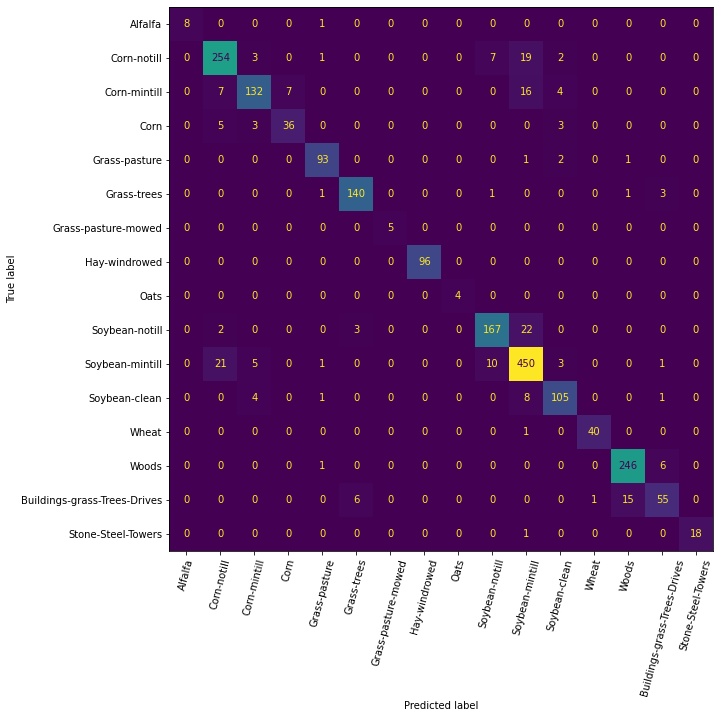

In [41]:
plot_classification_and_confusion_matrix(clf2, X2_test, Y2_test, class_names=classes_names_indiana_pines)

0.963236652503233
                           precision    recall  f1-score   support

    Brocoli_green_weeds_1       1.00      1.00      1.00       402
    Brocoli_green_weeds_2       1.00      1.00      1.00       745
                   Fallow       1.00      1.00      1.00       395
        Fallow_rough_plow       1.00      1.00      1.00       279
            Fallow_smooth       1.00      1.00      1.00       536
                  Stubble       1.00      1.00      1.00       792
                   Celery       1.00      1.00      1.00       716
         Grapes_untrained       0.88      0.96      0.92      2254
     Soil_vinyard_develop       1.00      1.00      1.00      1241
Corn_senesced_green_weeds       0.99      1.00      0.99       656
      Lettuce_romaine_4wk       1.00      1.00      1.00       213
      Lettuce_romaine_5wk       1.00      1.00      1.00       385
      Lettuce_romaine_6wk       1.00      1.00      1.00       183
      Lettuce_romaine_7wk       1.00      0

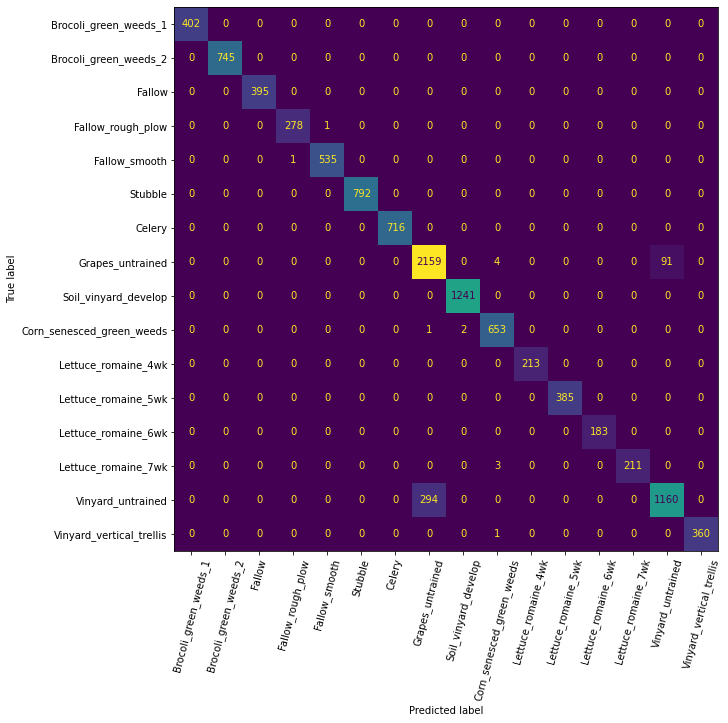

In [42]:
plot_classification_and_confusion_matrix(clf1, X1_test, Y1_test, class_names=classes_names_salinas)

In [43]:
#Function that returns an image based on the ground_truth and the prediction
#It is needed as the prediction does not take into account the ground
def reconstruct_image(ground_truth, prediction):
    original_img = ground_truth.flatten()
    indexes = np.array(np.where(original_img != 0))
    original_img[indexes] = prediction + 1
    return np.reshape(original_img, ground_truth.shape)

In [44]:
def display_each_class(clf, X, ground_truth, name_classes, nb_col):
    name_classes_with_ground = name_classes.copy()
    name_classes_with_ground.insert(0, "Ground")
    y_predict = clf.predict(X)
    y_predict_reshaped = reconstruct_image(ground_truth, y_predict)
    
    nb_classes = np.size(name_classes_with_ground)
    nb_row = (nb_classes * 2 // nb_col) + 1
    index = 0
    plt.figure(figsize=(15, 18))
    fig, axes = plt.subplots(nb_row, nb_col, figsize=(10,20))
    
    axes = axes.ravel()
    
    for i in range(nb_classes):
        axes[index].imshow(np.where(ground_truth == i, 1, 0), cmap="jet")
        axes[index].title.set_text(name_classes_with_ground[i])
        axes[index].set_xticklabels([])
        axes[index].set_yticklabels([])
        index += 1
        
        axes[index].imshow(np.where(y_predict_reshaped == i, 1, 0), cmap="jet")
        axes[index].set_xticklabels([])
        axes[index].set_yticklabels([])
        index += 1
    plt.show()

In [45]:
def denoise_each_class(clf, X, ground_truth):
    y_predict = clf.predict(X)
    y_predict_reshaped = reconstruct_image(ground_truth, y_predict)
    res = ground_truth.flatten()
    for c in range(1, 16):
        bin_class = np.where(y_predict_reshaped == c, 1, 0)
        bin_class = closing(bin_class, morpho.diamond(1))
        bin_class = opening(bin_class, morpho.diamond(1))
        res[bin_class.flatten()] = c
    return res.reshape(ground_truth.shape)

<Figure size 1080x1296 with 0 Axes>

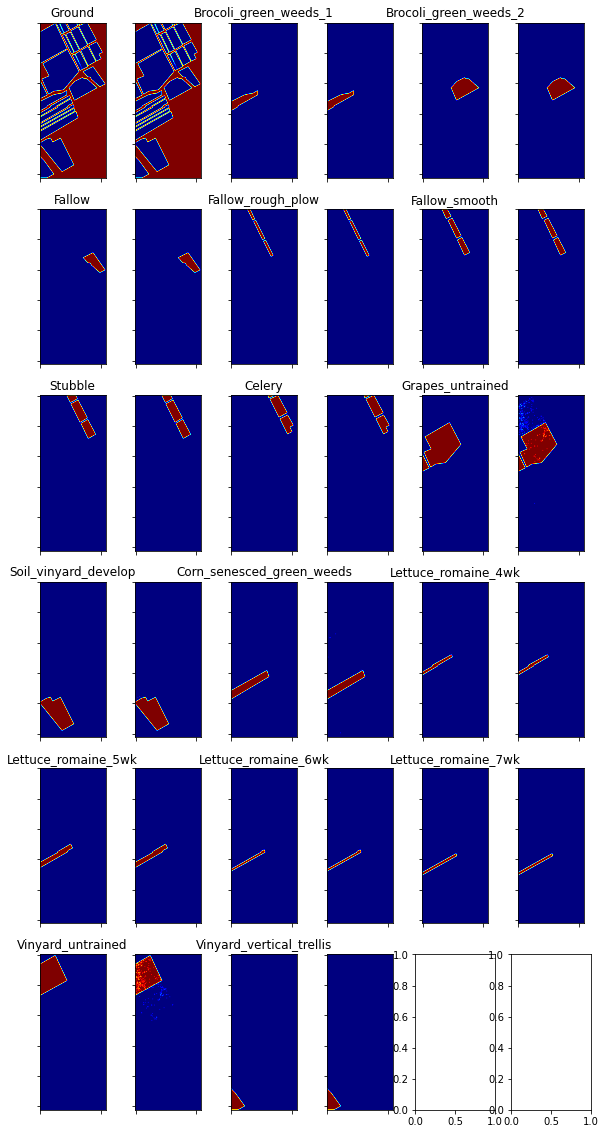

In [46]:
display_each_class(clf1, X1, salinas_gt, classes_names_salinas, nb_col=6)

In [47]:
from skimage.morphology import opening, closing
from skimage import morphology as morpho

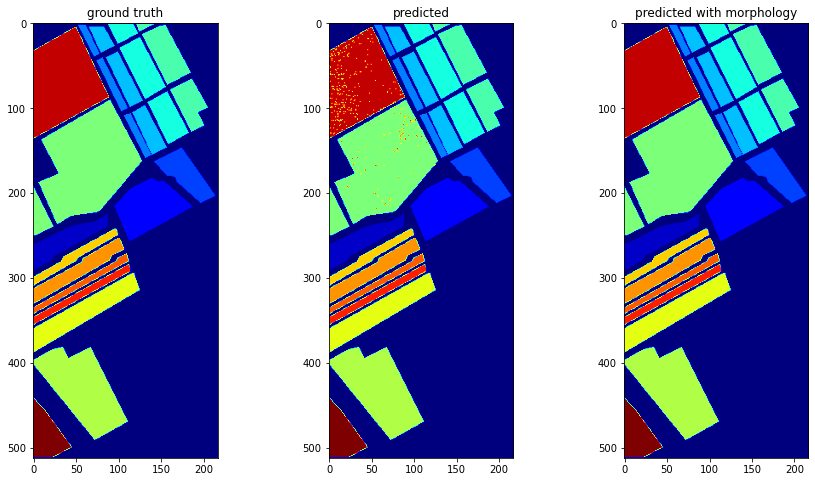

With morpho: 0.9999819988479263
Without morpho: 0.9964177707373272
error ratio: 199.00000000000617


In [50]:
y1_predict = clf1.predict(X1)

reconstructed_img_salinas = reconstruct_image(salinas_gt, y1_predict)

#y1_pred_rc = closing(reconstructed_img_salinas, morpho.diamond(1))
#y1_pred_rc = opening(y1_pred_rc, morpho.diamond(1))

y1_pred_rc = denoise_each_class(clf1, X1, salinas_gt)

plt.figure(figsize=(15,8))
plt.subplot(131)
plt.imshow(salinas_gt, cmap='jet')
plt.title("ground truth")

plt.subplot(132)
plt.imshow(reconstructed_img_salinas, cmap='jet')
plt.title("predicted")

plt.subplot(133)
plt.imshow(y1_pred_rc, cmap='jet')
plt.title("predicted with morphology")

plt.show()
morph = (y1_pred_rc == salinas_gt).flatten().sum() / (salinas_gt.shape[0] * salinas_gt.shape[1])
origin = (reconstructed_img_salinas == salinas_gt).flatten().sum() / (salinas_gt.shape[0] * salinas_gt.shape[1])
print("With morpho:", morph)
print("Without morpho:", origin)
# mathematical morphology have shown to divide the error by a factor of approximately 200
print("error ratio:", ((1 - origin)/(1 - morph)))

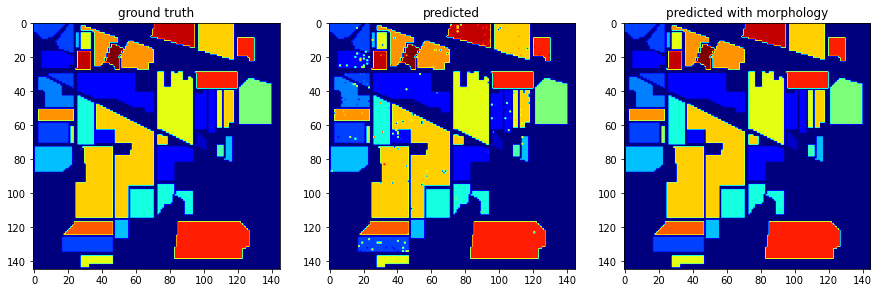

With morpho: 0.9999048751486326
Without morpho: 0.9904399524375743
error ratio: 100.4999999999965


In [51]:
y2_predict = clf2.predict(X2)

reconstructed_img_indiana = reconstruct_image(indiana_pines_gt, y2_predict)

#y2_pred_rc = closing(reconstructed_img_indiana, morpho.diamond(1))
#y2_pred_rc = opening(y2_pred_rc, morpho.diamond(1))

y2_pred_rc = denoise_each_class(clf2, X2, indiana_pines_gt)


plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(indiana_pines_gt, cmap='jet')
plt.title("ground truth")

plt.subplot(132)
plt.imshow(reconstructed_img_indiana, cmap='jet')
plt.title("predicted")

plt.subplot(133)
plt.imshow(y2_pred_rc, cmap='jet')
plt.title("predicted with morphology")

plt.show()
morph = (y2_pred_rc == indiana_pines_gt).flatten().sum() / (indiana_pines_gt.shape[0] * indiana_pines_gt.shape[1])
origin = (reconstructed_img_indiana == indiana_pines_gt).flatten().sum() / (indiana_pines_gt.shape[0] * indiana_pines_gt.shape[1])
print("With morpho:", morph)
print("Without morpho:", origin)

# Mathematical morphology have shown to divide the error by a factor of approximately 100
print("error ratio:", ((1 - origin)/(1 - morph)))